In [ ]:
!nvidia-smi
!pip install transformers
!pip install datasets
!pip install umap-learn

In [48]:
# Fine tune a BERT model for a classification task
from datasets import load_dataset 
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer 
from transformers import AutoModel
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
emotions = load_dataset("emotion")
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
def label_int2str(row, split):
  return emotions[split].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str, split="train")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


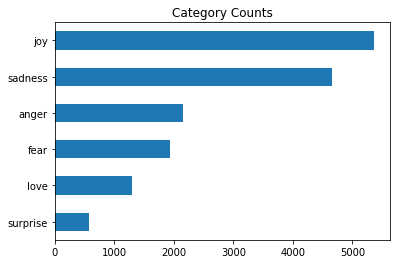

In [15]:
# Look at the class distribution
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts");

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


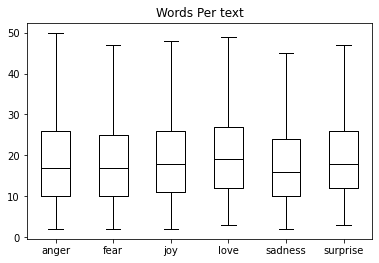

In [16]:
# Check length of text
df["Words Per text"] = df["text"].str.split().apply(len)
df.boxplot("Words Per text", by='label_name', grid=False, showfliers=False,
             color='black')
plt.suptitle("")
plt.xlabel("");

In [17]:
# Load a pretrained tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer.vocab_size)
print(f'special tokens: {tokenizer.special_tokens_map}\nmax_length: {tokenizer.model_max_length}')

30522
special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
max_length: 512


In [18]:
# Transformers as feature extractors
# Could be a random forest on top of the bert model parameters.
# It does not have to be a model that relies on gradients
# The feature-based method relies on the assumption that the hidden states 
# capture all the information necessary for the classification task.

model = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

emotions.reset_format()

In [ ]:
"""
For each batch, the input sequences are padded to the maximum sequence length 
in the batch. The attention mask is used in the model to 
ignore the padded areas of the input tensors.
"""

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
# Sanity check
assert len(emotions_encoded["train"][:4]['input_ids']) == 4

In [29]:
def forward_pass(batch):
  input_ids = torch.tensor(batch["input_ids"]).to(device)
  attention_mask = torch.tensor(batch["attention_mask"]).to(device)

  with torch.no_grad():
    last_hidden_state = model(input_ids, attention_mask).last_hidden_state.cpu()
    last_hidden_state = last_hidden_state.numpy()
  
  lhs_shape = last_hidden_state.shape
  # Negate because mask in np.ma.array(input, mask) takes true and false as inp
  # tokenizer's mask is 1 for keep and 0 for mask. So we have to reverse!

  boolean_mask = ~np.array(batch["attention_mask"]).astype(bool)
  boolean_mask = np.repeat(boolean_mask, lhs_shape[-1], axis=-1)
  boolean_mask = boolean_mask.reshape(lhs_shape)
  # output.last_hidden_state.shape
  # torch.Size([1, 6, 768]) We are taking the mean of the 6 tokens.
  masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1) 
  batch["hidden_state"] = masked_mean.data
  return batch

emotions_encoded = emotions_encoded.map(forward_pass, batched=True,
                                        batch_size=16)
emotions_encoded["train"].features

  0%|          | 0/1000 [00:00<?, ?ba/s]

  0%|          | 0/125 [00:00<?, ?ba/s]

  0%|          | 0/125 [00:00<?, ?ba/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'hidden_state': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

In [30]:
# Basic ML

X_train = np.array(emotions_encoded["train"]["hidden_state"])
X_valid = np.array(emotions_encoded["validation"]["hidden_state"])
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [34]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,6.259821,5.158913,0
1,1.663264,4.837403,0
2,5.631217,2.102412,3
3,2.444454,3.282328,2
4,0.487918,7.237328,3


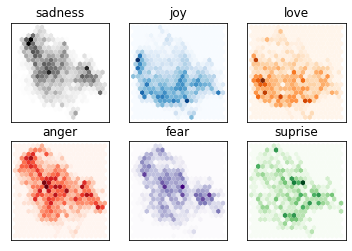

In [35]:
# Plot umap representations
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = ["sadness", "joy", "love", "anger", "fear", "suprise"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                 gridsize=20, linewidths=(0,))

  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])


In [36]:
lr_clf = LogisticRegression(n_jobs=-1, penalty="none")
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.646

In [38]:
# Now let's compare with sklearn's DummyClassifier that uses a simple heuristic
# to always choose the majority class or always draw a random class

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [42]:
y_preds = lr_clf.predict(X_valid)
print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

     sadness       0.66      0.72      0.69       550
         joy       0.71      0.81      0.75       704
        love       0.52      0.30      0.38       178
       anger       0.57      0.48      0.52       275
        fear       0.53      0.56      0.55       212
     suprise       0.52      0.30      0.38        81

    accuracy                           0.65      2000
   macro avg       0.59      0.53      0.55      2000
weighted avg       0.63      0.65      0.63      2000



In [ ]:
"""
Fine-tuning Transformers: we train the whole model end-to-end which also
updates the pretrained weights.
"""
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

In [55]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted") 
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [56]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size

training_args = TrainingArguments(output_dir="results",
                                    num_train_epochs=2,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    load_best_model_at_end=True,
                                    metric_for_best_model="f1",
                                    weight_decay=0.01,
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    evaluation_strategy = "no",
                                    save_strategy = 'no')

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state. If text, hidden_state are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Step,Training Loss
250,0.820000
500,0.246300




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=500, training_loss=0.5331597900390626, metrics={'train_runtime': 231.5502, 'train_samples_per_second': 138.199, 'train_steps_per_second': 2.159, 'total_flos': 720342861696000.0, 'train_loss': 0.5331597900390626, 'epoch': 2.0})

In [57]:
results = trainer.evaluate()
results

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state. If text, hidden_state are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


{'eval_loss': 0.2142593115568161,
 'eval_accuracy': 0.9255,
 'eval_f1': 0.9254466034632801,
 'eval_runtime': 4.5608,
 'eval_samples_per_second': 438.524,
 'eval_steps_per_second': 7.016,
 'epoch': 2.0}

In [58]:
preds_output = trainer.predict(emotions_encoded["validation"])
y_preds = np.argmax(preds_output.predictions, axis=1)
print(classification_report(y_valid, y_preds, target_names=labels))

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, hidden_state. If text, hidden_state are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       550
         joy       0.95      0.93      0.94       704
        love       0.82      0.89      0.86       178
       anger       0.92      0.94      0.93       275
        fear       0.86      0.90      0.88       212
     suprise       0.94      0.73      0.82        81

    accuracy                           0.93      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.93      0.93      0.93      2000

